# DNA standards

DNA standards are synthetic cDNA oligos complementary to RNA strand terminated with
  - `*A`: A-only tail with varying lengths (0, 15, 30, 60, 90 or 120);  
  - `*U`, `5G`, `5C`: 30 As followerd by either Us (1, 3 or 5), Gs (5) or Cs (5); 
  - `IntG`: 15 As followed by 3 GAAAA repeats

We prefiltered only the reads for which
the alignment starts in expected reference posittion (+/-1).
For example, for 0A, 60A and 120A,
the alignments should start at position
1, 61 and 121 of the reference, respectively 
(adding 12 bases that are typically lost from 5'-end by ONT sequencing). 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob

## Tail length

PolyTailor underestimates tail length, therefore we normalise it by a factor `a` optionally adding `b`. 

Additionally, you can choose to include only reads with selected filters ie `OK` and `no_pT`. 

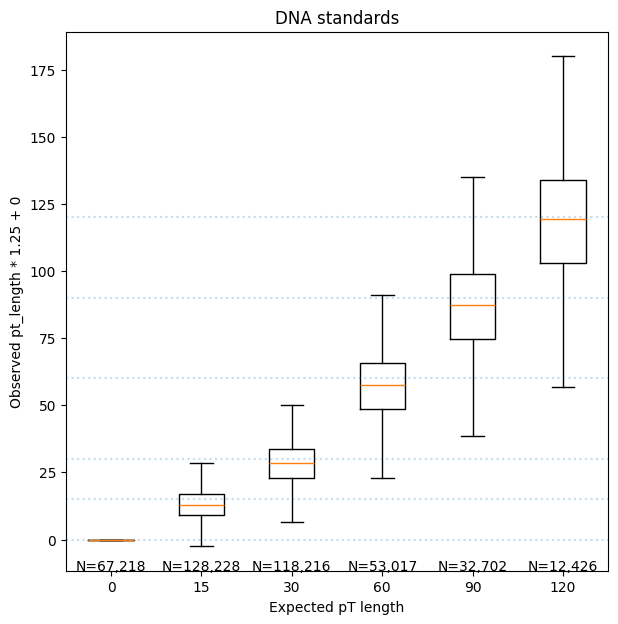

In [367]:
y = "pt_length"
a, b = 1.25, 0
#a, b = 1.25, 2
data = []
fn = "../test/minimap2/DNA_standards/%sA.bam.pT.tsv.gz"
pt_lengths = (0, 15, 30, 60, 90, 120)
for pt_len in pt_lengths:
    df = pd.read_csv(fn%pt_len, sep="\t") 
    #sizes = df.loc[df["filter"].isin(("OK", "no_pT")), y].to_numpy() * a + b
    sizes = df[y].to_numpy() * a + b
    data.append(sizes)

fig, ax = plt.subplots(figsize=(7, 7))
_ = ax.boxplot(data, positions=np.arange(len(data)), labels=pt_lengths, showfliers=False)
ymin, _  = ax.get_ylim()
for tick, label in enumerate(ax.get_xticklabels()):
    ax.text(tick, ymin, f"N={len(data[tick]):,}", color='black',  horizontalalignment="center") # medians[tick]
_ = ax.hlines(pt_lengths, *ax.get_xlim(), ls=":", alpha=0.25)
ax.set_xlabel("Expected pT length"); 
ax.set_ylabel(f"Observed {y} * {a} + {b}"); 
ax.set_title("DNA standards")
fig.savefig("DNA_standards.length.png")
fig.savefig("DNA_standards.length.pdf")

### tail length from `pt_seq`

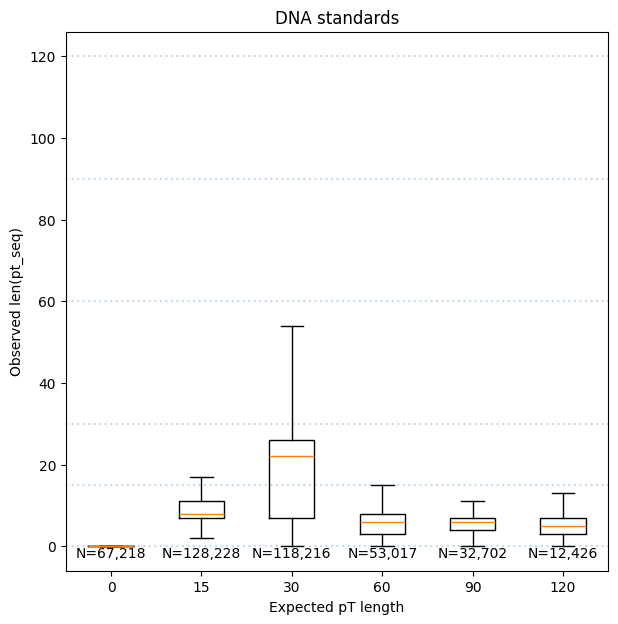

In [368]:
y = "pt_seq"
data = []
fn = "../test/minimap2/DNA_standards/%sA.bam.pT.tsv.gz"
pt_lengths = (0, 15, 30, 60, 90, 120)
for pt_len in pt_lengths:
    df = pd.read_csv(fn%pt_len, sep="\t") 
    # get rid of nan
    df.loc[df[y].isna(), y] = ''
    sizes = np.array(list(map(len, df[y].to_numpy())))
    data.append(sizes)

fig, ax = plt.subplots(figsize=(7, 7))
_ = ax.boxplot(data, positions=np.arange(len(data)), labels=pt_lengths, showfliers=False)
ymin, _  = ax.get_ylim()
for tick, label in enumerate(ax.get_xticklabels()):
    ax.text(tick, ymin, f"N={len(data[tick]):,}", color='black',  horizontalalignment="center") # medians[tick]
_ = ax.hlines(pt_lengths, *ax.get_xlim(), ls=":", alpha=0.25)
ax.set_xlabel("Expected pT length"); 
ax.set_ylabel(f"Observed len({y})") 
ax.set_title("DNA standards")
#fig.savefig("DNA_standards.len_pt_seq.png")
fig.savefig("DNA_standards.len_pt_seq.pdf")

## composition

- heterogenous tail bases
- tail ends

In [314]:
!pip install logomaker
import logomaker
import sys
from collections import Counter

bases = 'ACGU'
base2idx = {b: i for i, b in enumerate(bases)}
base2rnacomplement = {'A': 'U', 'T': 'A', 'C': 'G', 'G': 'C'}

fn = "../test/minimap2/DNA_standards/%s.bam.pT.tsv.gz"

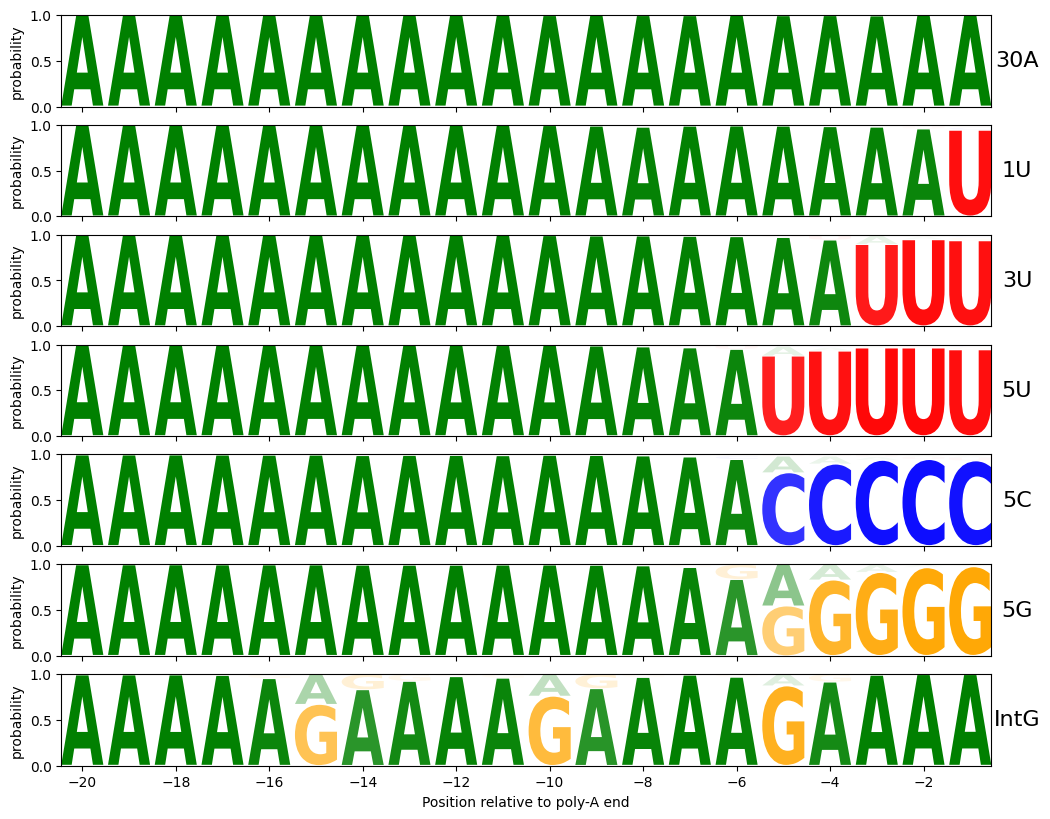

In [350]:
samples = ("30A", "1U", "3U", "5U", "5C", "5G", "IntG")
filters = ('OK', 'not_continuous', 'not_continuous', 'not_continuous', 'not_continuous', 'not_continuous', 'OK')
N = 20
cols = ['primer_end', 'pt_start', 'before_pt', 'pt_seq']
fig, axes = plt.subplots(len(samples), figsize=(12, 1+1.25*len(samples)), sharex="col")
for ax, (s, f) in zip(axes, zip(samples, filters)): 
    sys.stderr.write(f"{s}  \r")
    df = pd.read_csv(fn%s, sep="\t")
    # get counts
    counts = np.zeros((len(bases), N), dtype='int')
    for primer_end, pt_start, before_pt, pt_seq in df.loc[df['filter']==f, cols].to_numpy():
        term_bases = pt_start-primer_end; term_bases
        seq = before_pt[-term_bases:] + pt_seq if term_bases>0 else pt_seq
        # get reverse complement
        seq_rc = [base2rnacomplement[b] for b in seq[::-1]]
        idx = N-len(seq_rc) if len(seq)<N else 0
        for i, b in enumerate(seq_rc[-N:], idx):
            if i==N: break
            counts[base2idx[b], i] += 1
    # and freq
    freq = counts / counts.sum(axis=0)
    # df
    probs = pd.DataFrame(freq.T, columns=list(bases), index=range(-N, 0)); df
    # write logo
    logo = logomaker.Logo(probs, ax=ax, width=.9, vpad=.02, fade_probabilities=True, stack_order='small_on_top',)
    #ax.set_title(s, y=0.5, loc='right')
    ax.text(0., 0.5, s, fontsize=16, ha='center', va='center')
    ax.set_ylabel("probability")
ax.set_xticks(range(-N, 0, 2))
ax.set_xlabel("Position relative to poly-A end")
fig.savefig("DNA_standards.composition.png")
fig.savefig("DNA_standards.composition.pdf")